# Unsupervised Regime Labelling

**Prepared by:** Adisorn Promkaewngarm  

# Import Libraries

In [ ]:
!pip -q install hmmlearn

In [ ]:
!pip -q install mplfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hmmlearn
from hmmlearn.hmm import GaussianHMM, GMMHMM
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import mplfinance as mpf
import joblib
import warnings
warnings.filterwarnings('ignore')

# Import Data

In [ ]:
# Define the paths
path_SET = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/SET_Index_Weekly_2010_2025.csv'

# Loading and setting the index
df_set = pd.read_csv(path_SET, index_col='Date', parse_dates=True)
df_set = df_set.loc['2011-01-03':]

print(f"Index Data Start Date: {df_set.index.min()}")
print(f"Index Data End Date: {df_set.index.max()}")

Index Data Start Date: 2011-01-03 00:00:00
Index Data End Date: 2025-12-29 00:00:00


# Features Engineering

In [ ]:
# Add return features

# 1. Initialize the feature dataframe with the target log return
df_SET_features = np.log(df_set['Close'] / df_set['Open']).to_frame(name='log_ret_t0')

# 2. Calculate Open-to-High and Open-to-Low log return
df_SET_features['SET_OH_log_ret'] = np.log(df_set['High'] / df_set['Open'])
df_SET_features['SET_OL_log_ret'] = np.log(df_set['Low'] / df_set['Open'])

In [ ]:
df_SET_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 783 entries, 2011-01-03 to 2025-12-29
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   log_ret_t0      783 non-null    float64
 1   SET_OH_log_ret  783 non-null    float64
 2   SET_OL_log_ret  783 non-null    float64
dtypes: float64(3)
memory usage: 24.5 KB


## Descriptive Statistics for Full data

In [ ]:
import pandas as pd
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller

# 1. Initialize dictionary to store metrics
eda_metrics = {}

for col in df_SET_features.columns:
    series = df_SET_features[col]

    # Jarque-Bera Test (Normality)
    # H0: The data is normally distributed (Bell Curve).
    # Ha: The data is NOT normally distributed (Skewed or Fat Tails).
    jb_stat, jb_p = jarque_bera(series)

    # Augmented Dickey-Fuller Test (Stationarity)
    # H0: The series is NON-STATIONARY (contains a unit root).
    # Ha: The series is STATIONARY (mean and variance are stable over time).
    adf_result = adfuller(series)
    adf_p = adf_result[1]

    eda_metrics[col] = {
        'Mean': series.mean()*52,
        'Median': series.median()*52,
        'Std Dev': series.std()*np.sqrt(52),
        'Skewness': series.skew(),
        'Kurtosis': series.kurtosis(),
        'Normality (p-val)': jb_p,
        'Stationary (p-val)': adf_p
    }

# 2. Create the summary dataframe
df_stat_table = pd.DataFrame(eda_metrics).T

# 3. Display the results
print("Consolidated Statistical Table: SET Log Returns (2011-2025)")
df_stat_table.round(6)

Consolidated Statistical Table: SET Log Returns (2011-2025)


,Mean,Median,Std Dev,Skewness,Kurtosis,Normality (p-val),Stationary (p-val)
log_ret_t0,-0.001844,0.039648,0.138064,-0.495176,3.621656,0.0,0.0
SET_OH_log_ret,0.648222,0.490119,0.086818,1.905120,4.908319,0.0,0.0
SET_OL_log_ret,-0.772113,-0.521244,0.125306,-5.633595,65.727358,0.0,0.0


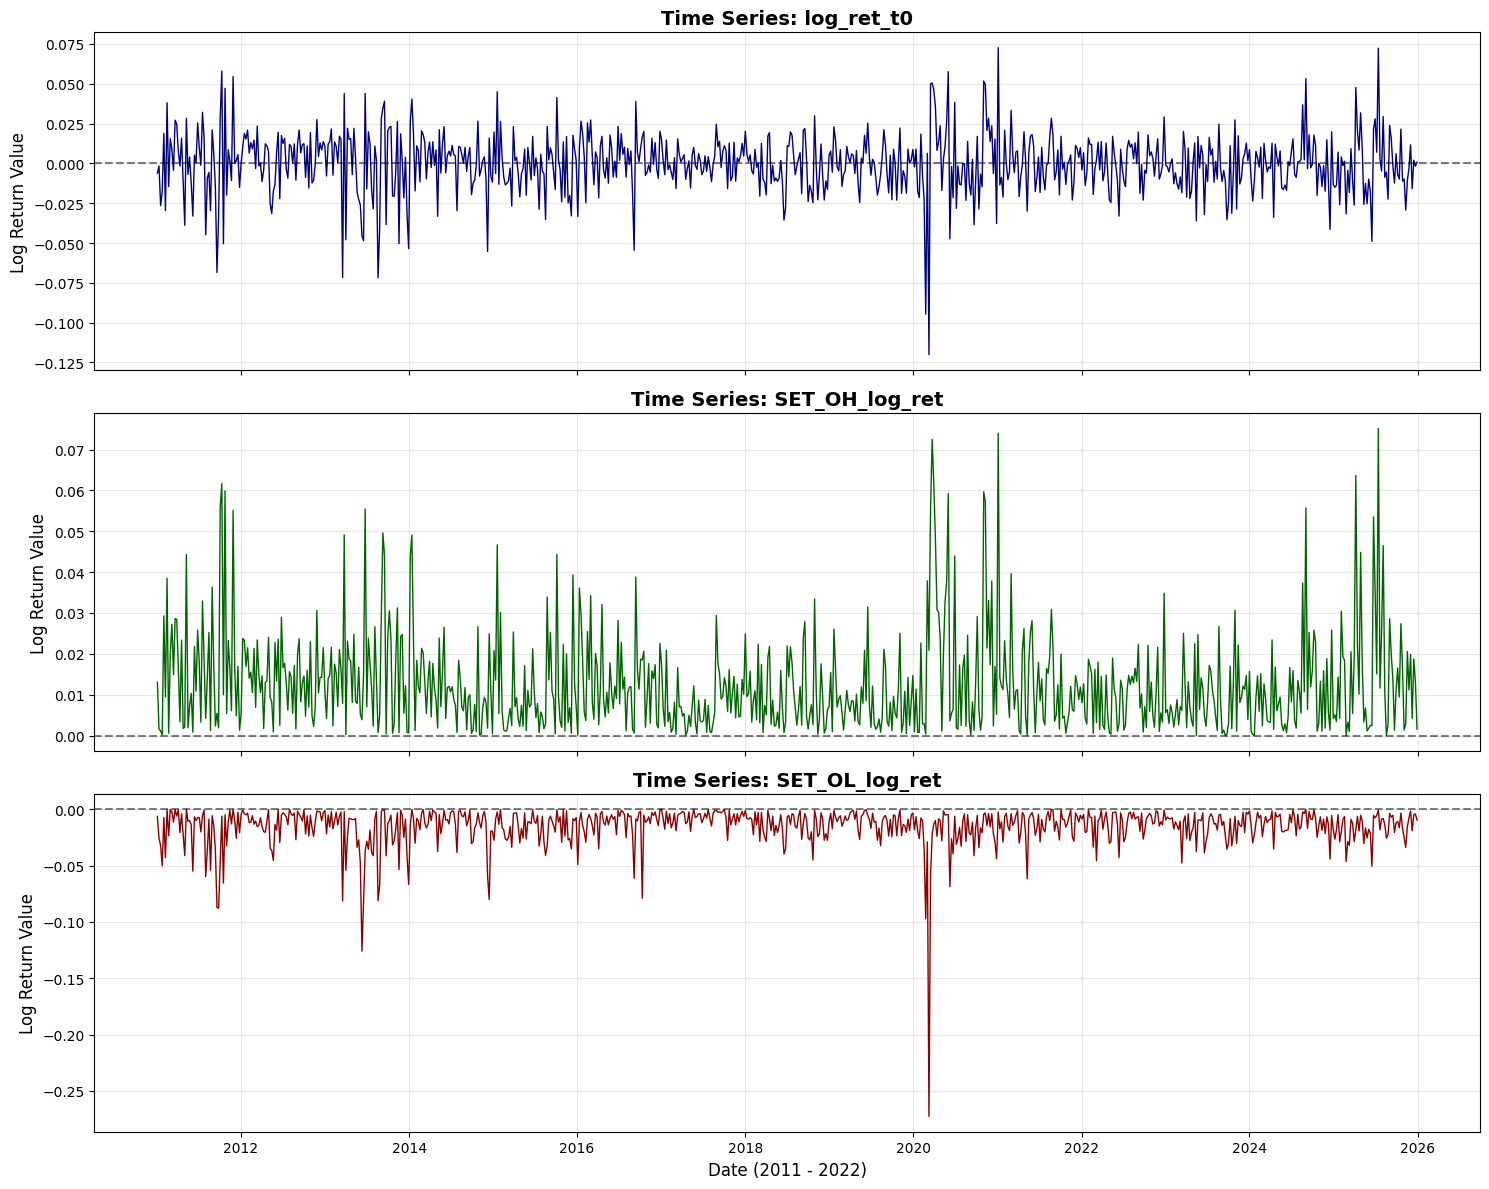

In [ ]:
# Create subplots for synchronized time-series analysis
# We share the x-axis (dates) to compare specific weeks across all variables
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Define distinct colors for clarity
colors = ['navy', 'darkgreen', 'darkred']

for i, col in enumerate(df_SET_features.columns):
    # Plot the time series
    axes[i].plot(df_SET_features.index, df_SET_features[col], color=colors[i], linewidth=1)

    # Add a horizontal line at 0 to emphasize the oscillation
    axes[i].axhline(0, color='black', linestyle='--', alpha=0.5)

    # Precise Labeling
    axes[i].set_title(f'Time Series: {col}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Log Return Value', fontsize=12)
    axes[i].grid(True, alpha=0.3)

# Label the shared x-axis
plt.xlabel('Date (2011 - 2022)', fontsize=12)
plt.tight_layout()
plt.show()

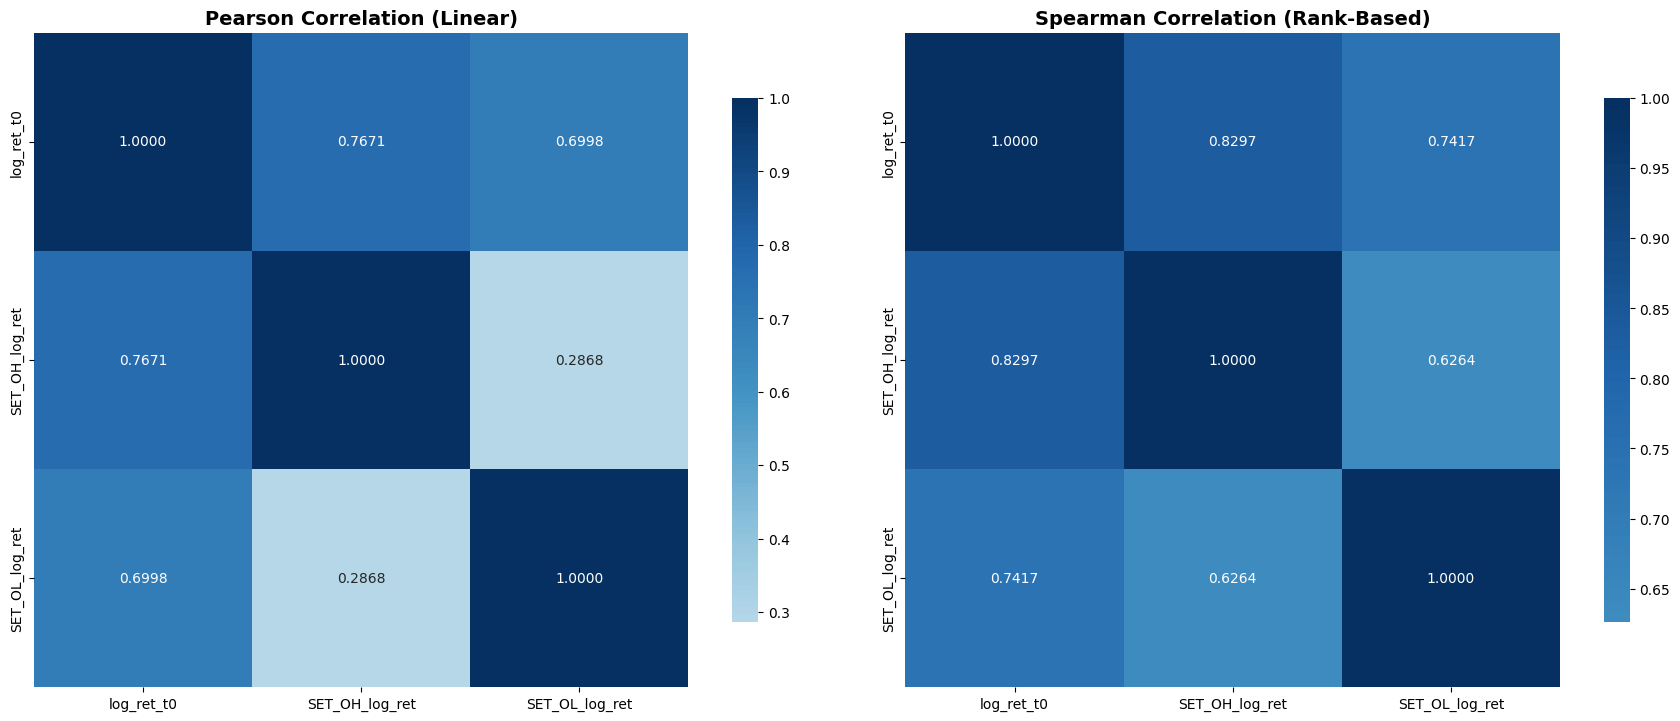

In [ ]:
# 1. Calculate Correlation Matrices
corr_pearson = df_SET_features.corr(method='pearson')
corr_spearman = df_SET_features.corr(method='spearman')

# 2. Setup Subplots for comparison
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Pearson Heatmap
sns.heatmap(corr_pearson, annot=True, fmt=".4f", cmap='RdBu', center=0, ax=ax[0], square=True, cbar_kws={'shrink': .8})
ax[0].set_title('Pearson Correlation (Linear)', fontsize=14, fontweight='bold')

# Spearman Heatmap
sns.heatmap(corr_spearman, annot=True, fmt=".4f", cmap='RdBu', center=0, ax=ax[1], square=True, cbar_kws={'shrink': .8})
ax[1].set_title('Spearman Correlation (Rank-Based)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Filter training data

In [ ]:
# Slicing for the 2011-2022 training period
df_train = df_SET_features.loc['2011-01-01':'2022-12-31']
df_set_train = df_set.loc['2011-01-01':'2022-12-31']

# EDA

## Decriptive Statistics for Training Period

In [ ]:
# Select the first three columns (0, 1, 2)
df_eda = df_train.copy()

In [ ]:
import pandas as pd
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller

# 1. Initialize dictionary to store metrics
eda_metrics = {}

for col in df_eda.columns:
    series = df_eda[col]

    # Jarque-Bera Test (Normality)
    # H0: The data is normally distributed (Bell Curve).
    # Ha: The data is NOT normally distributed (Skewed or Fat Tails).
    jb_stat, jb_p = jarque_bera(series)

    # Augmented Dickey-Fuller Test (Stationarity)
    # H0: The series is NON-STATIONARY (contains a unit root).
    # Ha: The series is STATIONARY (mean and variance are stable over time).
    adf_result = adfuller(series)
    adf_p = adf_result[1]

    eda_metrics[col] = {
        'Mean': series.mean()*52,
        'Median': series.median()*52,
        'Std Dev': series.std()*np.sqrt(52),
        'Skewness': series.skew(),
        'Kurtosis': series.kurtosis(),
        'Normality (p-val)': jb_p,
        'Stationary (p-val)': adf_p
    }

# 2. Create the summary dataframe
df_stat_table = pd.DataFrame(eda_metrics).T

# 3. Display the results
print("Consolidated Statistical Table: SET Log Returns (2011-2022)")
df_stat_table.round(6)

Consolidated Statistical Table: SET Log Returns (2011-2022)


,Mean,Median,Std Dev,Skewness,Kurtosis,Normality (p-val),Stationary (p-val)
log_ret_t0,0.022702,0.087124,0.140660,-0.706983,3.982832,0.0,0.0
SET_OH_log_ret,0.657126,0.517363,0.086192,1.825606,4.475829,0.0,0.0
SET_OL_log_ret,-0.779521,-0.515929,0.134929,-5.585974,60.818079,0.0,0.0


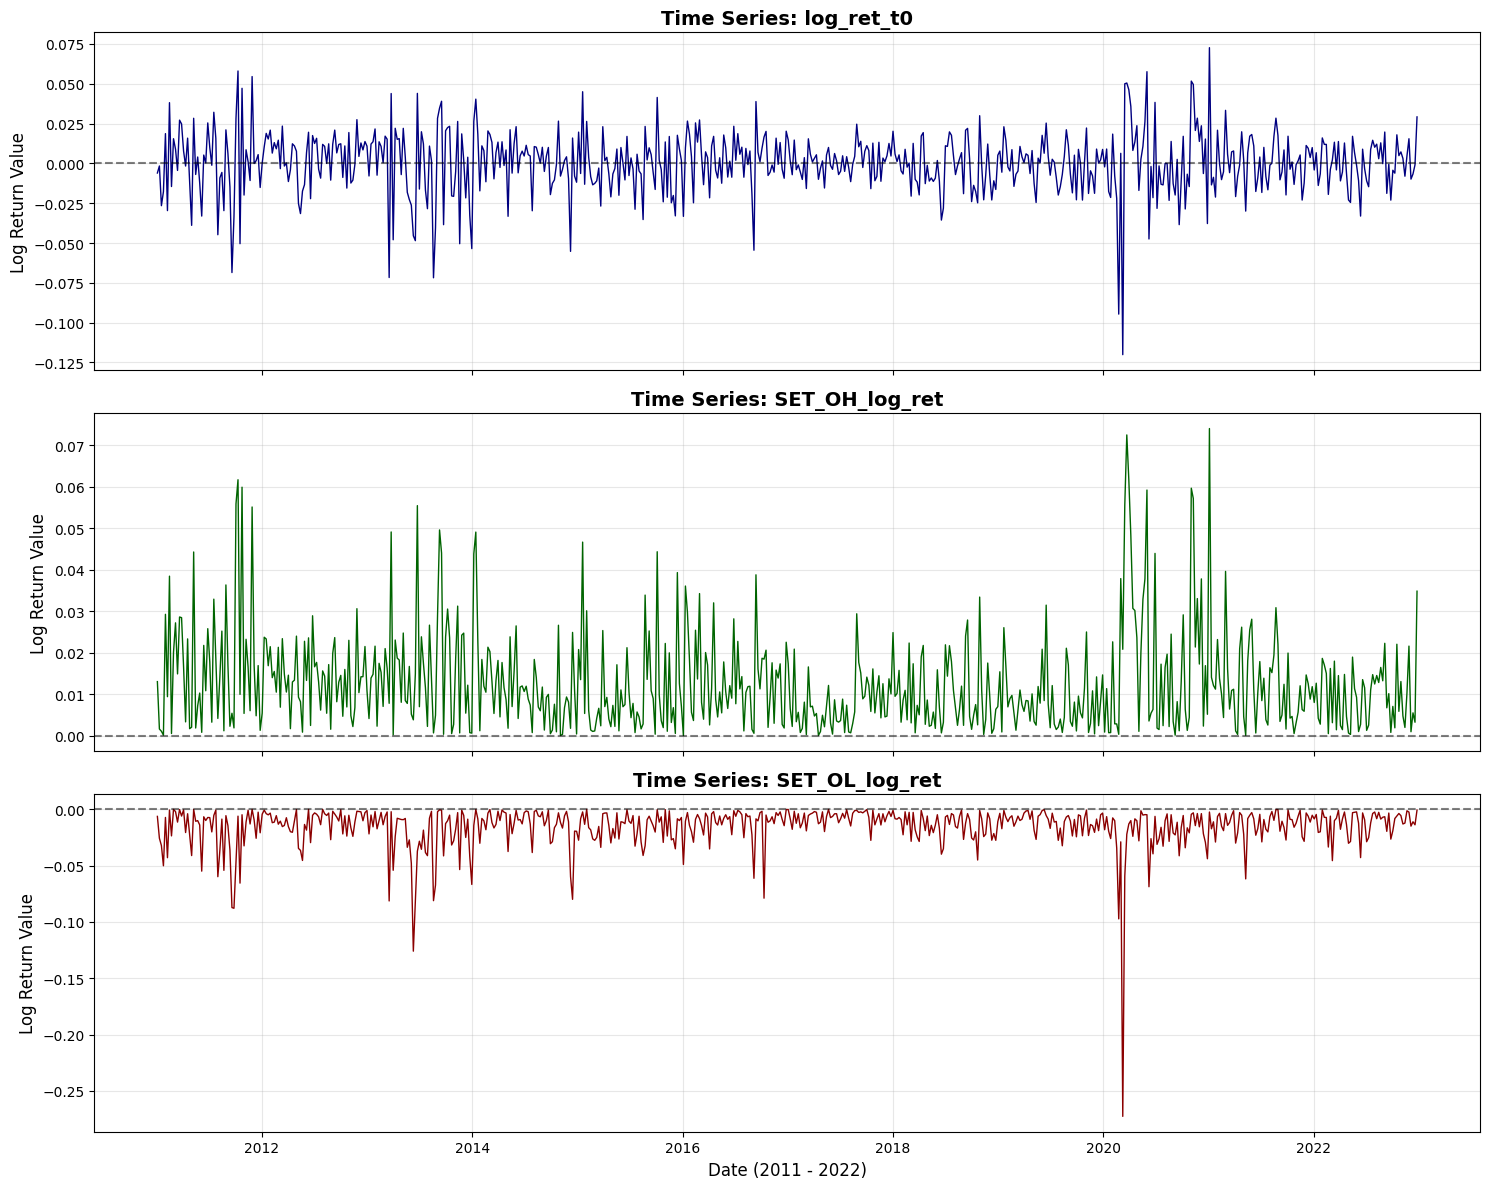

In [ ]:
# Create subplots for synchronized time-series analysis
# We share the x-axis (dates) to compare specific weeks across all variables
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Define distinct colors for clarity
colors = ['navy', 'darkgreen', 'darkred']

for i, col in enumerate(df_eda.columns):
    # Plot the time series
    axes[i].plot(df_eda.index, df_eda[col], color=colors[i], linewidth=1)

    # Add a horizontal line at 0 to emphasize the oscillation
    axes[i].axhline(0, color='black', linestyle='--', alpha=0.5)

    # Precise Labeling
    axes[i].set_title(f'Time Series: {col}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Log Return Value', fontsize=12)
    axes[i].grid(True, alpha=0.3)

# Label the shared x-axis
plt.xlabel('Date (2011 - 2022)', fontsize=12)
plt.tight_layout()
plt.show()

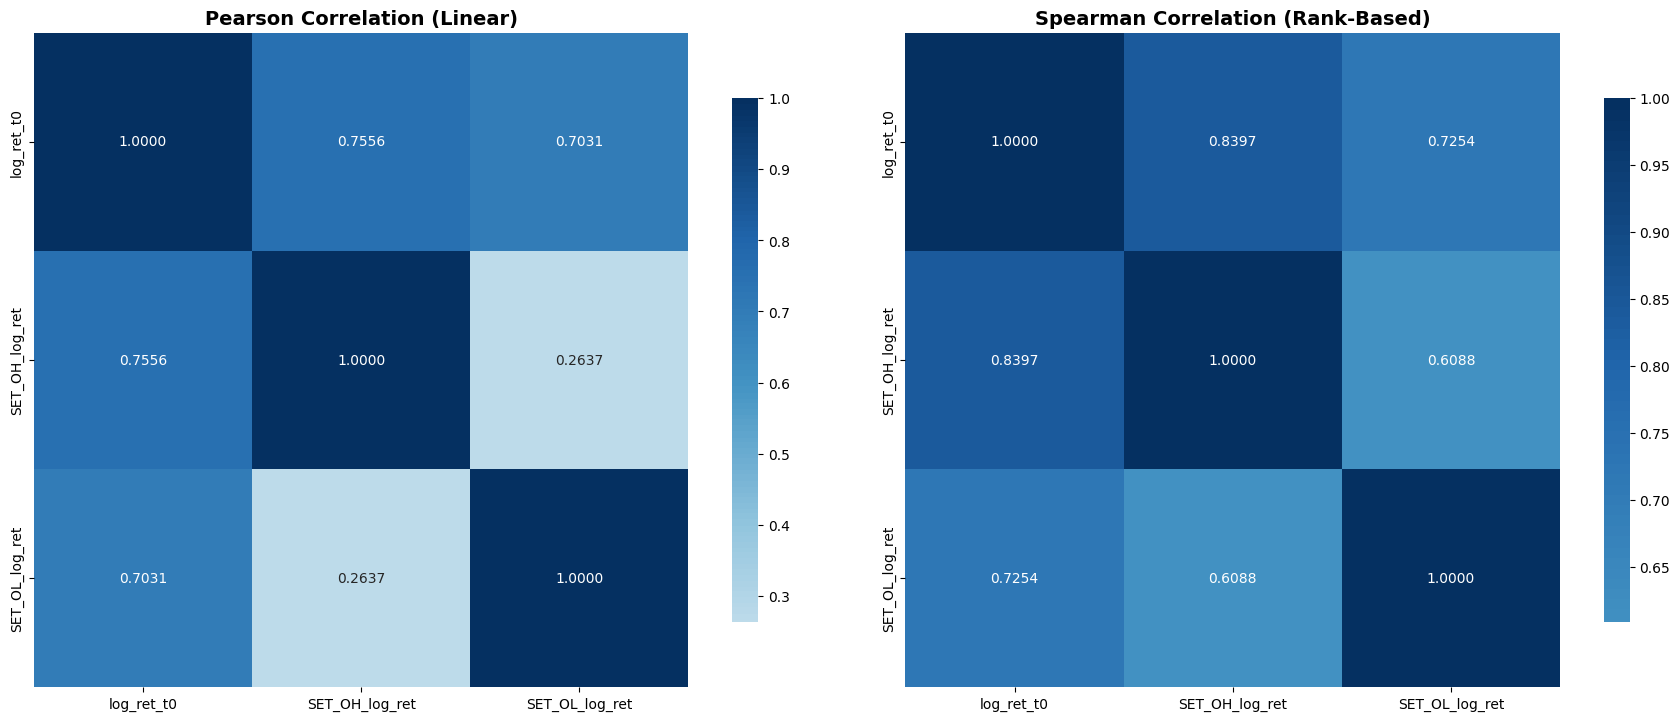

In [ ]:
# 1. Calculate Correlation Matrices
corr_pearson = df_eda.corr(method='pearson')
corr_spearman = df_eda.corr(method='spearman')

# 2. Setup Subplots for comparison
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Pearson Heatmap
sns.heatmap(corr_pearson, annot=True, fmt=".4f", cmap='RdBu', center=0, ax=ax[0], square=True, cbar_kws={'shrink': .8})
ax[0].set_title('Pearson Correlation (Linear)', fontsize=14, fontweight='bold')

# Spearman Heatmap
sns.heatmap(corr_spearman, annot=True, fmt=".4f", cmap='RdBu', center=0, ax=ax[1], square=True, cbar_kws={'shrink': .8})
ax[1].set_title('Spearman Correlation (Rank-Based)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# HMM model selection

In [ ]:
model_comparison_list = []

from sklearn.preprocessing import StandardScaler

# Define the features to be standardized within the training period
features_to_scale = ['log_ret_t0', 'SET_OH_log_ret', 'SET_OL_log_ret']

# Initialize the StandardScaler
scaler = StandardScaler()

# Rescale and replace the values directly in df_train
# This maintains the original index (2011-2022) and column names
df_train[features_to_scale] = scaler.fit_transform(df_train[features_to_scale])

## Helper function

In [ ]:
from hmmlearn.hmm import GaussianHMM, GMMHMM
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def run_hmm_research_pipeline(data_train, data_price, model_type='gaussian', n_regimes=3, n_mix_range=[1]):
    """
    Robust Research Pipeline:
    1. Grid searches across Covariance and Mixture counts.
    2. Always returns the best model based on BIC to prevent list collection errors.
    3. Returns: (model, results_df, stats_df)
    """
    is_multivariate = data_train.shape[1] > 1
    dim_str = "Multivariate" if is_multivariate else "Univariate"
    type_str = "GMM-HMM" if model_type.lower() == 'gmm' else "Gaussian HMM"
    full_model_name = f"{dim_str} {type_str}"

    X = data_train.values
    if X.ndim == 1: X = X.reshape(-1, 1)

    cov_types = ['full', 'diag', 'tied', 'spherical']
    best_bic = np.inf
    best_model = None
    best_params = {}

    print(f"--- Starting {full_model_name} Grid Search ---")

    for ct in cov_types:
        for nm in n_mix_range:
            try:
                if model_type.lower() == 'gmm':
                    model = GMMHMM(n_components=n_regimes, n_mix=nm, covariance_type=ct,
                                   n_iter=2000, random_state=42)
                else:
                    model = GaussianHMM(n_components=n_regimes, covariance_type=ct,
                                        n_iter=2000, random_state=42)
                model.fit(X)

                curr_bic = model.bic(X)
                if curr_bic < best_bic:
                    best_bic = curr_bic
                    best_model = model
                    best_params = {'cov': ct, 'n_mix': nm if model_type == 'gmm' else 1}
            except Exception:
                continue

    # Extract Metrics
    log_lik = best_model.score(X)
    aic_val = best_model.aic(X)
    is_conv = best_model.monitor_.converged

    df_res = data_train.copy()
    df_res['Regime'] = best_model.predict(X)

    # Annualized Stats
    target_col = data_train.columns[0]
    stats = df_res.groupby('Regime')[target_col].agg(['mean', 'std', 'count'])
    stats['Ann. Return'] = stats['mean'] * 52
    stats['Ann. Volatility'] = stats['std'] * np.sqrt(52)
    regime_stats = stats[['Ann. Return', 'Ann. Volatility', 'count']].rename(columns={'count': 'Freq (Weeks)'})
    regime_stats = regime_stats.sort_values('Ann. Volatility')

    # Print Report
    print("\n" + "="*60)
    print(f"TITLE: {full_model_name} | CONVERGED: {is_conv}")
    print(f"Best Cov: {best_params['cov']} | BIC: {best_bic:.2f}")
    print("="*60)
    print(regime_stats.to_string())

    return best_model, df_res, regime_stats

## Univariate Gaussian HMM

In [ ]:
# 1.1 Select Univariate Feature
features_L1 = ['log_ret_t0']
df_input_L1 = df_train[features_L1]

# 1.2 Execute Research Pipeline
# Returning: Model Object, Result Dataframe, and Annualized Stats Table
model_L1, df_results_L1, stats_L1 = run_hmm_research_pipeline(
    data_train=df_input_L1,
    data_price=df_train,
    model_type='gaussian',
    n_regimes=3
)

# 1.3 Log Results to Comparison List
L1_entry = {
    'Level': 'Level 1',
    'Model': 'Univariate Gaussian HMM',
    'Covariance': model_L1.covariance_type,
    'n_mix': 1,
    'AIC': model_L1.aic(df_input_L1.values),
    'BIC': model_L1.bic(df_input_L1.values),
    'Log-Lik': model_L1.score(df_input_L1.values),
    'Converged': model_L1.monitor_.converged
}

model_comparison_list.append(L1_entry)

--- Starting Univariate Gaussian HMM Grid Search ---

TITLE: Univariate Gaussian HMM | CONVERGED: True
Best Cov: spherical | BIC: 1727.05
        Ann. Return  Ann. Volatility  Freq (Weeks)
Regime                                            
0          4.713926         4.875933           246
1         -2.793432         5.235263           246
2         -3.525681        12.213073           134


## Univariate GM-HMM

In [ ]:
# 2.1 Select Univariate Feature
features_L2 = ['log_ret_t0']
df_input_L2 = df_train[features_L2]

# 2.2 Execute Research Pipeline (Testing n_mix 1-3)
model_L2, df_results_L2, stats_L2 = run_hmm_research_pipeline(
    data_train=df_input_L2,
    data_price=df_train,
    model_type='gmm',
    n_regimes=3,
    n_mix_range=[1, 2, 3]
)

# 2.3 Log Results to Comparison List
L2_entry = {
    'Level': 'Level 2',
    'Model': 'Univariate GMM-HMM',
    'Covariance': model_L2.covariance_type,
    'n_mix': model_L2.n_mix,
    'AIC': model_L2.aic(df_input_L2.values),
    'BIC': model_L2.bic(df_input_L2.values),
    'Log-Lik': model_L2.score(df_input_L2.values),
    'Converged': model_L2.monitor_.converged
}

model_comparison_list.append(L2_entry)

--- Starting Univariate GMM-HMM Grid Search ---



TITLE: Univariate GMM-HMM | CONVERGED: True
Best Cov: diag | BIC: 1727.08
        Ann. Return  Ann. Volatility  Freq (Weeks)
Regime                                            
0          4.713926         4.875933           246
1         -2.787569         5.224627           247
2         -3.542076        12.259219           133


## Multivariate Gaussian HMM

In [ ]:
# 3.1 Select Multivariate Features
features_L3 = ['log_ret_t0', 'SET_OH_log_ret', 'SET_OL_log_ret']
df_input_L3 = df_train[features_L3]

# 3.2 Execute Research Pipeline
model_L3, df_results_L3, stats_L3 = run_hmm_research_pipeline(
    data_train=df_input_L3,
    data_price=df_train,
    model_type='gaussian',
    n_regimes=3
)

# 3.3 Log Results to Comparison List
L3_entry = {
    'Level': 'Level 3',
    'Model': 'Multivariate Gaussian HMM',
    'Covariance': model_L3.covariance_type,
    'n_mix': 1,
    'AIC': model_L3.aic(df_input_L3.values),
    'BIC': model_L3.bic(df_input_L3.values),
    'Log-Lik': model_L3.score(df_input_L3.values),
    'Converged': model_L3.monitor_.converged
}

model_comparison_list.append(L3_entry)

--- Starting Multivariate Gaussian HMM Grid Search ---

TITLE: Multivariate Gaussian HMM | CONVERGED: True
Best Cov: full | BIC: 3050.17
        Ann. Return  Ann. Volatility  Freq (Weeks)
Regime                                            
0          3.026775         4.583524           465
2         45.809337         7.516816            95
1        -87.262688         7.757983            66


## Multivariate GMM-HMM

In [ ]:
# 4.1 Select Multivariate Features
features_L4 = ['log_ret_t0', 'SET_OH_log_ret', 'SET_OL_log_ret']
df_input_L4 = df_train[features_L4]

# 4.2 Execute Research Pipeline
model_L4, df_results_L4, stats_L4 = run_hmm_research_pipeline(
    data_train=df_input_L4,
    data_price=df_train,
    model_type='gmm',
    n_regimes=3,
    n_mix_range=[1, 2, 3]
)

# 4.3 Log Results to Comparison List
L4_entry = {
    'Level': 'Level 4',
    'Model': 'Multivariate GMM-HMM',
    'Covariance': model_L4.covariance_type,
    'n_mix': model_L4.n_mix,
    'AIC': model_L4.aic(df_input_L4.values),
    'BIC': model_L4.bic(df_input_L4.values),
    'Log-Lik': model_L4.score(df_input_L4.values),
    'Converged': model_L4.monitor_.converged
}

model_comparison_list.append(L4_entry)

--- Starting Multivariate GMM-HMM Grid Search ---



TITLE: Multivariate GMM-HMM | CONVERGED: True
Best Cov: diag | BIC: 878.65
        Ann. Return  Ann. Volatility  Freq (Weeks)
Regime                                            
0          0.312263         4.475805           249
2         47.381264         5.351805           176
1        -41.874906         6.401048           201


## Model Comparison

In [ ]:
# 5.1 Convert the metrics list into a final DataFrame
df_model_comparison = pd.DataFrame(model_comparison_list)

# 5.2 Clean up the display columns for better readability
cols_to_show = ['Level', 'Model', 'Covariance', 'n_mix', 'Log-Lik', 'AIC', 'BIC']
df_comparison_final = df_model_comparison[cols_to_show].copy()

# 5.3 Sort by BIC (Lowest BIC = Best Statistical Fit)
df_comparison_final = df_comparison_final.sort_values('BIC').reset_index(drop=True)

# 5.4 Display the Table
print("="*85)
print("FINAL HMM FRAMEWORK COMPARISON: SET INDEX (2011-2022)")
print("="*85)
df_comparison_final

FINAL HMM FRAMEWORK COMPARISON: SET INDEX (2011-2022)


,Level,Model,Covariance,n_mix,Log-Lik,AIC,BIC
0,Level 4,Multivariate GMM-HMM,diag,3,-233.267342,594.534683,878.653107
1,Level 1,Univariate Gaussian HMM,spherical,1,-818.450077,1664.900154,1727.051059
2,Level 2,Univariate GMM-HMM,diag,1,-818.462199,1664.924399,1727.075304
3,Level 3,Multivariate Gaussian HMM,full,1,-1412.396499,2894.792999,3050.170262


# Best Model Results

In [ ]:
# --- CORRECTED STATISTICS CALCULATION ---

# 1. Re-calculate the UNSCALED log returns from the price dataframe
# This ensures we get real percentages, not Z-score stats
unscaled_ret_t0 = np.log(df_set_train['Close'] / df_set_train['Open'])

# 2. Align the Regime labels (from scaled HMM) with the unscaled returns
# We use the index to ensure perfect alignment
df_stats_calc = pd.DataFrame(index=df_results_L4.index)
df_stats_calc['Regime'] = df_results_L4['Regime']
df_stats_calc['Unscaled_Ret'] = unscaled_ret_t0

# 3. Calculate the actual annualized stats
corrected_stats_L4 = df_stats_calc.groupby('Regime')['Unscaled_Ret'].agg(['mean', 'std', 'count'])
corrected_stats_L4['Ann. Return'] = corrected_stats_L4['mean'] * 52
corrected_stats_L4['Ann. Volatility'] = corrected_stats_L4['std'] * np.sqrt(52)

# 4. Cleanup and Sort
# Sorting by Ann. Return makes it easy to identify Bear (lowest) and Bull (highest)
corrected_stats_L4 = corrected_stats_L4[['Ann. Return', 'Ann. Volatility', 'count']].rename(columns={'count': 'Freq (Weeks)'})
corrected_stats_L4 = corrected_stats_L4.sort_values('Ann. Return')

# 5. Final Display Formatting
print("="*60)
print("WINNING MODEL: MULTIVARIATE GM-HMM (STATISTICS CORRECTED)")
print("="*60)

formatted_stats_L4 = corrected_stats_L4.copy()
formatted_stats_L4['Ann. Return'] = formatted_stats_L4['Ann. Return'].map('{:.2%}'.format)
formatted_stats_L4['Ann. Volatility'] = formatted_stats_L4['Ann. Volatility'].map('{:.2%}'.format)

print("ANNUALIZED REGIME CHARACTERISTICS (BASED ON RAW MARKET DATA)")
formatted_stats_L4

WINNING MODEL: MULTIVARIATE GM-HMM (STATISTICS CORRECTED)
ANNUALIZED REGIME CHARACTERISTICS (BASED ON RAW MARKET DATA)


,Ann. Return,Ann. Volatility,Freq (Weeks)
Regime,,,
1,-79.35%,12.48%,201
0,2.88%,8.72%,249
2,94.62%,10.43%,176


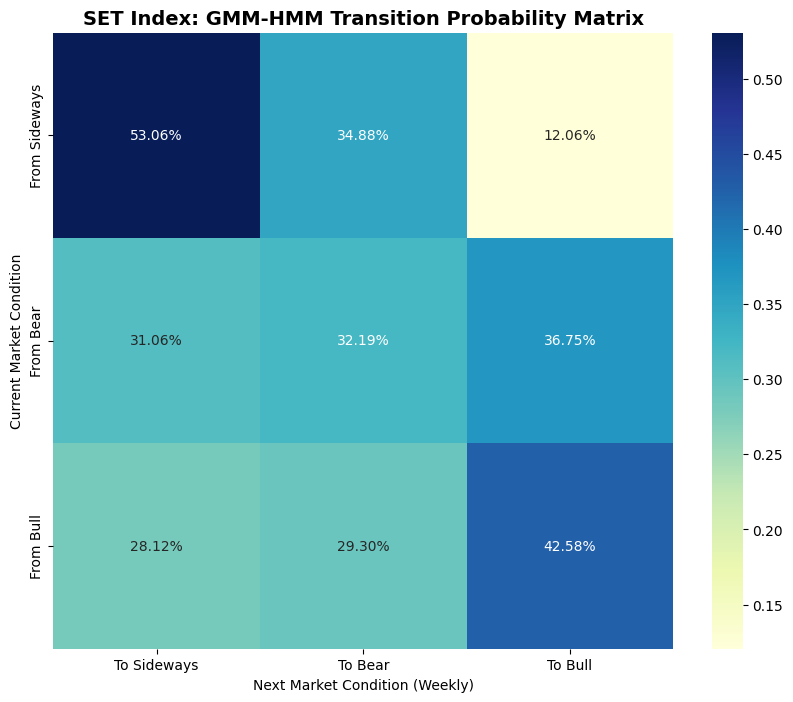

Market Regime   | Stay Prob.   | Exp. Duration
Sideways        |      53.06% |     2.13 weeks
Bear            |      32.19% |     1.47 weeks
Bull            |      42.58% |     1.74 weeks


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Extract the transition matrix from the trained model
# model_L4 should be your fitted GMMHMM object
transition_matrix = model_L4.transmat_

# 2. Define labels based on your verified mapping:
# 0 = Sideways, 1 = Bear, 2 = Bull
regime_names = ['Sideways', 'Bear', 'Bull']

# 3. Calculate Persistence and Expected Duration
# Persistence is the diagonal: the probability of staying in the same state
persistence = np.diag(transition_matrix)
# Duration formula: 1 / (1 - P(stay))
expected_duration = 1 / (1 - persistence)

# 4. Create a DataFrame for the Heatmap
df_trans = pd.DataFrame(
    transition_matrix,
    index=[f'From {n}' for n in regime_names],
    columns=[f'To {n}' for n in regime_names]
)

# 5. Visualization: Probability Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_trans, annot=True, fmt=".2%", cmap='YlGnBu', cbar=True)
plt.title('SET Index: GMM-HMM Transition Probability Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Current Market Condition')
plt.xlabel('Next Market Condition (Weekly)')
plt.show()

# 6. Print the Persistence and Duration Report
print("="*60)
print(f"{'Market Regime':<15} | {'Stay Prob.':<12} | {'Exp. Duration'}")
print("="*60)
for i, name in enumerate(regime_names):
    print(f"{name:<15} | {persistence[i]:>11.2%} | {expected_duration[i]:>8.2f} weeks")
print("="*60)

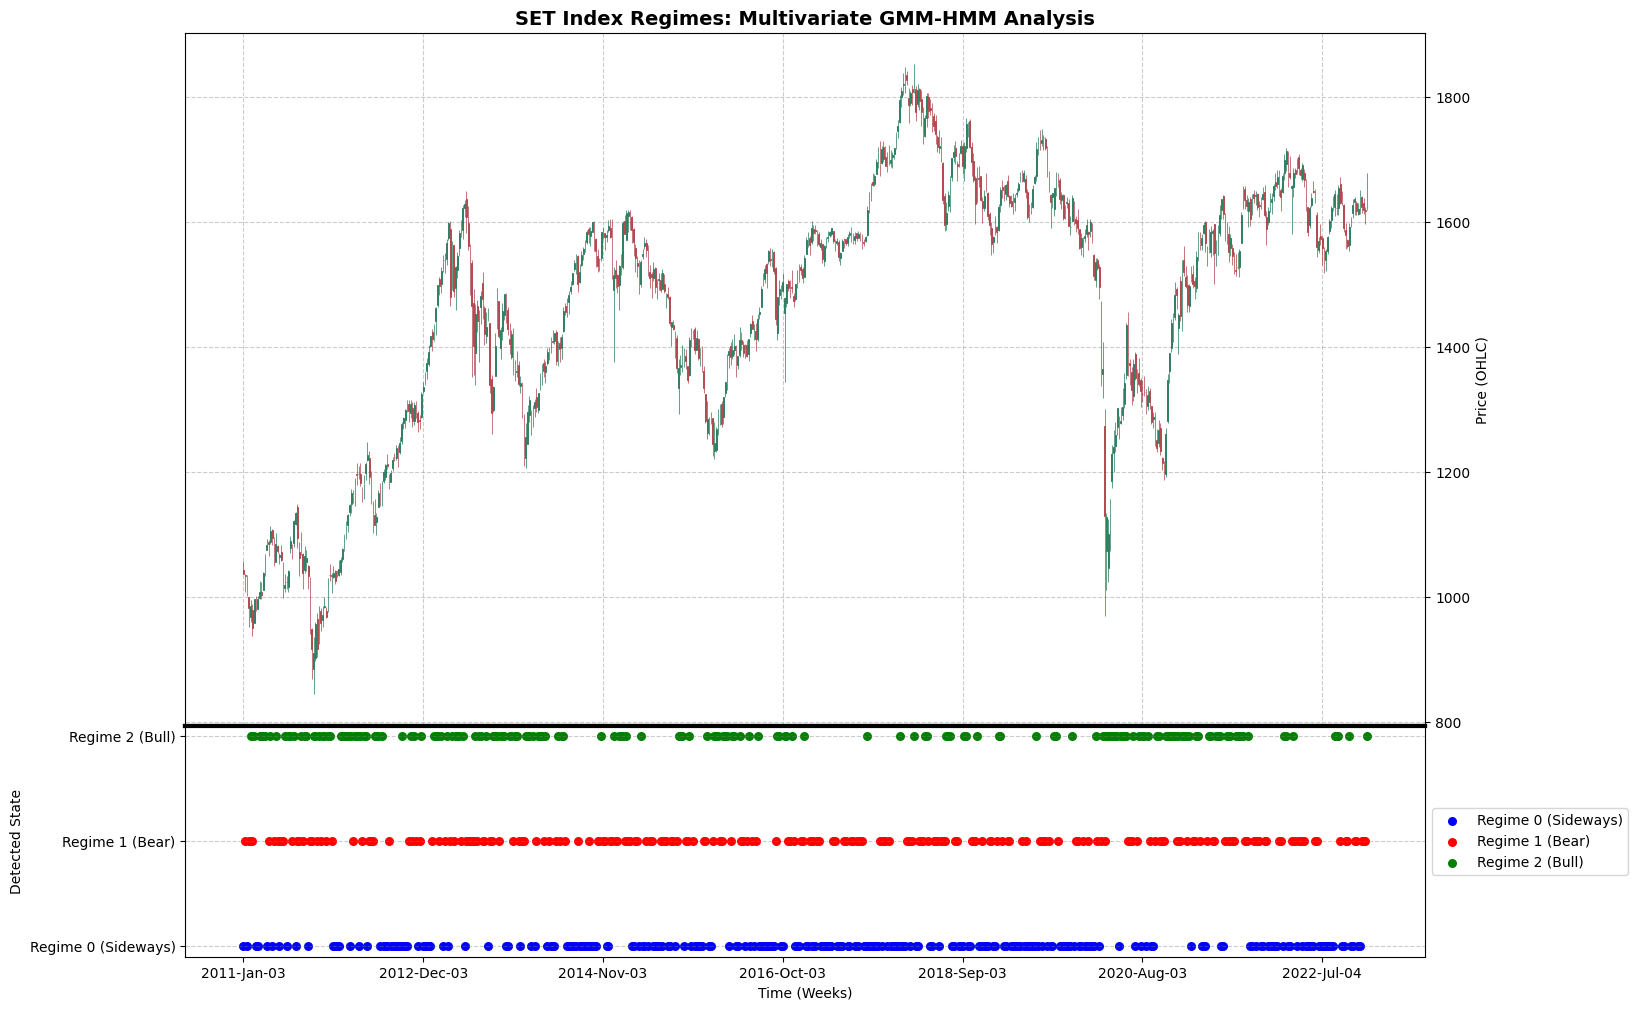

In [ ]:
import matplotlib.pyplot as plt
import mplfinance as mpf

# 1. Prepare Data for Visualization
df_candle = df_set_train[['Open', 'High', 'Low', 'Close']].copy()
df_candle['Regime'] = df_results_L4['Regime']

# Define Mapping and Labels (Updated: 0=Sideways, 1=Bear, 2=Bull)
# Sideways = Blue, Bear = Red, Bull = Green
color_map = {0: 'blue', 1: 'red', 2: 'green'}
regime_labels = {
    0: 'Regime 0 (Sideways)',
    1: 'Regime 1 (Bear)',
    2: 'Regime 2 (Bull)'
}

# 2. Final Visualization: Dual-Panel Candlestick & Regime Scatter
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True,
                                gridspec_kw={'height_ratios': [3, 1]})

# Top Panel: Candlestick Price Action
mpf.plot(
    df_candle,
    type='candle',
    style='charles',
    ax=ax1,
    show_nontrading=False
)
ax1.set_title('SET Index Regimes: Multivariate GMM-HMM Analysis', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price (OHLC)')

# Clearer Grid for Price Panel
ax1.grid(True, which='both', linestyle='--', linewidth=0.8, color='gray', alpha=0.4)

# Bold Separator Line (Bottom of ax1)
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['bottom'].set_color('black')

# Bottom Panel: Regime Identification Scatter Plot
x_axis = range(len(df_candle))
for r_id, r_color in color_map.items():
    mask = df_candle['Regime'] == r_id
    # Aligning scatter points with candle indices
    indices = [x_axis[i] for i in range(len(mask)) if mask.iloc[i]]
    ax2.scatter(indices, df_candle['Regime'][mask],
                color=r_color, s=30, label=regime_labels[r_id])

# Update y-ticks to match the new regime IDs
ax2.set_yticks([0, 1, 2])
# Updated labels to match: 0=Sideways, 1=Bear, 2=Bull
ax2.set_yticklabels(['Regime 0 (Sideways)', 'Regime 1 (Bear)', 'Regime 2 (Bull)'])
ax2.set_ylabel('Detected State')
ax2.set_xlabel('Time (Weeks)')

# Clearer Grid for Regime Panel
ax2.grid(True, which='both', linestyle='--', linewidth=0.8, color='gray', alpha=0.4, axis='y')

# Bold Separator Line (Top of ax2)
ax2.spines['top'].set_linewidth(3)
ax2.spines['top'].set_color('black')

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Eliminate gap between subplots for the single bold line effect
plt.subplots_adjust(hspace=0.0)

plt.show()

In [ ]:
# 1. Create the Consolidated Dataframe
# Using the index from df_train to ensure dates are preserved
df_final_regimes = pd.DataFrame(index=df_train.index)

# 2. Add the Price and Numerical Regime
df_final_regimes['Regime_ID'] = df_results_L4['Regime']

# 3. Define the Mapping (Revised: 0=Sideways, 1=Bear, 2=Bull)
# This aligns the ID with the discovered 'Slow Bleed' characteristics
regime_map = {
    0: 'Sideways',
    1: 'Bear',
    2: 'Bull'
}

# 4. Map the Labels
df_final_regimes['Regime_Label'] = df_final_regimes['Regime_ID'].map(regime_map)

# 5. Summary Count
print("\n--- Market Condition Distribution ---")
print(df_final_regimes['Regime_Label'].value_counts())


--- Market Condition Distribution ---
Regime_Label
Sideways    249
Bear        201
Bull        176
Name: count, dtype: int64


In [ ]:
# Export Train Label
if True: # Set as True to export
  df_final_regimes.to_csv('df_regime_labeling_traindata_weekly.csv', index=True)

In [ ]:
# Export Model
if False: # Set as True to export
  joblib.dump(model_L4, 'model_multivariate_gm_hmm_weekly.pkl')

##